# PHYS 432 - Assignment 4 - Adiabatic Shocks

Ruijia Yang, 2022-03-23. Code taken from "Evolving sound wave; isothermal perturbation" written by prof. Lee.

__Overview__

0. Background

1. Code and visualization.

2. Answers to the two questions.

### Background:

Hydro equations:

| | | |
| --- | --- | --- |
| 1 | $\partial_tf_1 + \partial_x(uf_1) = 0$ | $f_1 = \rho$ |
| 2 | $\partial_tf_2 + \partial_x(uf_2) = -\partial_x P$ | $f_2 = \rho u$ |
| 3 | $\partial_tf_3 + \partial_x(uf_3) = -\partial_x(Pu)$ | $f_3 = \rho e_{\rm tot}$ |

The implementation is operator splitting, where the source term (RHS) will be added after solving the LHS. For equations 1 and 2, the implementation is already in place in the given code, but also in the numerical notes. However, changes need to be made considering the process is now adiabatic: 

For adiabatic process, the barotropic EOS is $P = K\rho^{\gamma}$.

In addition, $\epsilon = \frac{1}{\gamma-1}\frac{P}{\rho}$ and $e_{\rm tot} = \frac{1}{2}u^2+h$, where specific enthalpy $h = \epsilon + \frac{P}{\rho}$. Thus combining the above, 

$\epsilon = e_{tot}-\frac{1}{2}u^2-\frac{P}{\rho} = \frac{1}{\gamma-1}\frac{P}{\rho} \implies e_{tot}-\frac{1}{2}u^2 = \left(\frac{\gamma}{\gamma-1}\right)\frac{P}{\rho} \implies P = \frac{\gamma-1}{\gamma}\left(\rho e_{\rm tot}-\frac{1}{2}\rho u^2\right) = \frac{\gamma-1}{\gamma}\left(f_3-\frac{f_2^2}{2f_1}\right)$

Pressure: $P = \frac{2}{5}\left(f_3-\frac{f_2^2}{2f_1}\right)$.

Sound speed: $c_s^2 = \frac{\gamma P}{\rho} = \frac{5P}{3f_1}$.

Finally, from equation 3: numerical implementation is $f_{3,i}^{n+1} = f_{3,i}^{n+1/2} - \frac{\Delta t}{2\Delta x}(P_{i+1}u_{i+1}-P_{i-1}u_{i-1})$.

### Code and visualization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Setting up  grid, time and grid spacing:

In [2]:
Ngrid = 100
Nsteps = 800
dt = 0.01
dx = 2.0

#### Setting up the initial conditions:
- $\rho(t=0) = 1$

- $u(t=0) = 0$

- $\rho e_{\rm tot}(t=0) = 1+\delta(\rho e_{\rm tot})$

In [3]:
x = np.arange(Ngrid) * dx  # grid
f1 = np.ones(Ngrid)        # rho
f2 = np.zeros(Ngrid)       # rho * u
f3 = np.ones(Ngrid)        # rho * e_tot; will add perturbation later.
u = np.zeros(Ngrid+1)      # advective velocity (keep the 1st and last element zero)

pres = np.zeros(Ngrid)
sound_sp = np.zeros(Ngrid)

#### Apply initial Gaussian perturbation

In [4]:
Amp, sigma = 10000, Ngrid/12
f3 = f3 + Amp * np.exp(-(x - x.max()/2) ** 2 / sigma ** 2)

#### Advecting with time

In [5]:
def advection(f, u, dt, dx):
    # calculating flux terms
    J = np.zeros(len(f)+1) # keeping the first and the last term zero
    J[1:-1] = np.where(u[1:-1] > 0, f[:-1] * u[1:-1], f[1:] * u[1:-1])
    f = f - (dt / dx) * (J[1:] - J[:-1]) # update
    return f

#### Plotting:

<IPython.core.display.Javascript object>


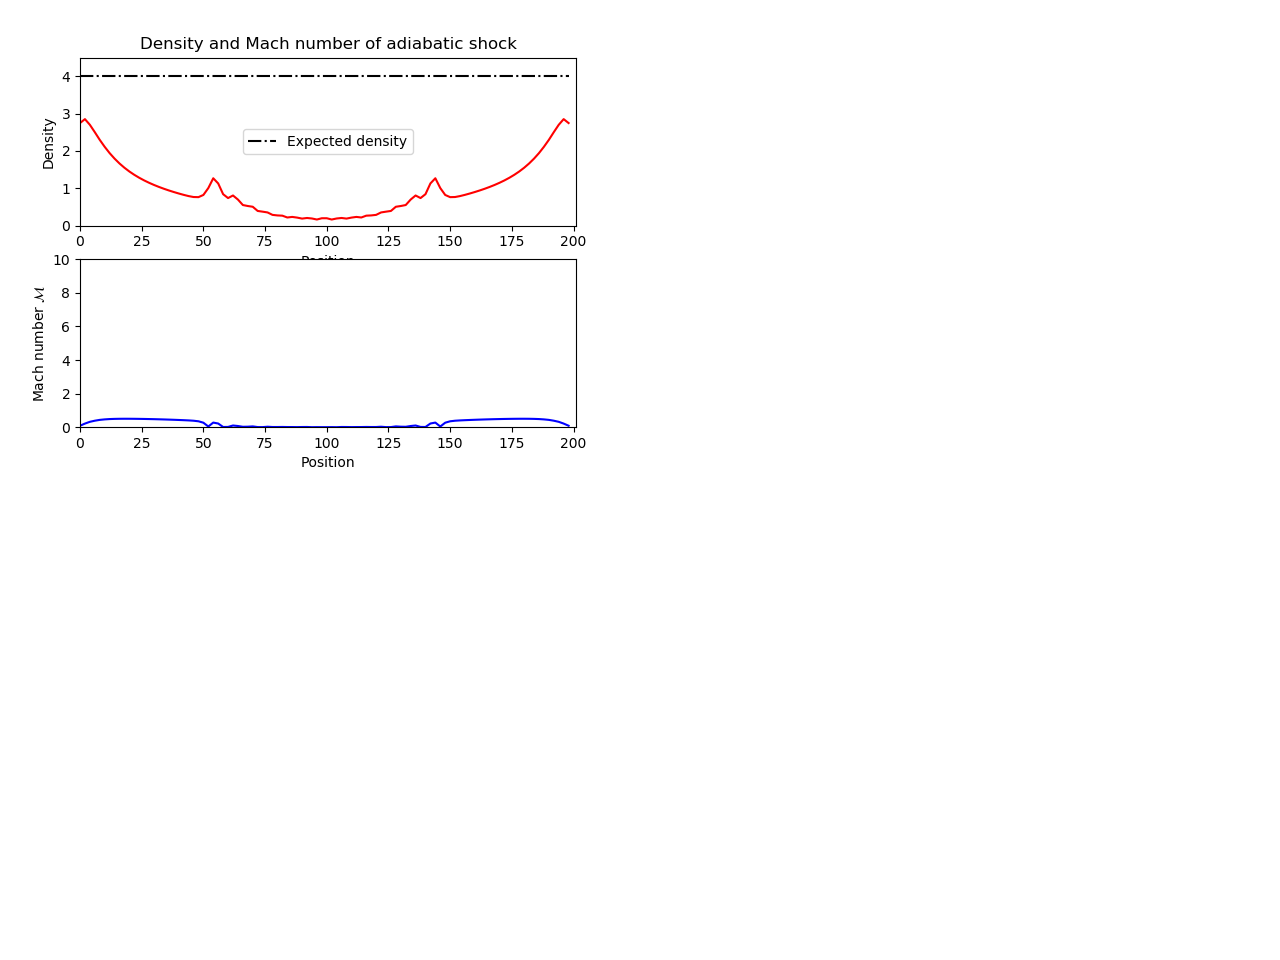

In [6]:
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots(2,1)

special_density = np.zeros(Ngrid)
special_velocity = np.zeros(Ngrid)

ax[0].plot(x, np.ones(Ngrid)*4, 'k-.')
ax[0].legend(['Expected density'])
x1, = ax[0].plot(x, f1, 'r-')
x2, = ax[1].plot(x, f2, 'b-')

ax[0].set_xlim([0, dx*Ngrid+1])
ax[0].set_ylim([0, 4.5])
ax[1].set_xlim([0, dx*Ngrid+1])
ax[1].set_ylim([0, 10])

ax[0].set_xlabel('Position')
ax[1].set_xlabel('Position')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('Mach number $\mathcal{M}$')
ax[0].set_title('Density and Mach number of adiabatic shock')

fig.canvas.draw()

for ct in range(Nsteps):
    # advection velocity at the cell interface
    u[1:-1] = 0.5 * ((f2[:-1] / f1[:-1]) + (f2[1:] / f1[1:]))

    # update density, momentum and total energy
    f1 = advection(f1, u, dt, dx)
    f2 = advection(f2, u, dt, dx)

    # update pressure
    pres = (2/5)*(f3 - ((f2**2)/(2*f1)))
    
    # add the source term for Euler equation
    f2[1:-1] = f2[1:-1] - 0.5 * (dt / dx) * (pres[2:] - pres[:-2])

    # correct for source term at the boundary (reflective)
    f2[0] = f2[0] - 0.5 * (dt / dx) * (pres[1] - pres[0])
    f2[-1] = f2[-1] - 0.5 * (dt / dx) * (pres[-1] - pres[-2])

    # advection velocity at the cell interface again
    u[1:-1] = 0.5 * ((f2[:-1] / f1[:-1]) + (f2[1:] / f1[1:]))
    
    # advect energy
    f3 = advection(f3, u, dt, dx)
    
    # pressure again
    pres = (2/5)*(f3 - ((f2**2)/(2*f1)))
    
    # add source term for energy equation
    f3[1:-1] = f3[1:-1] - 0.5 * (dt / dx) * ((f2[2:]/f1[2:])*pres[2:] - (f2[:-2]/f1[:-2])*pres[:-2])
    
    # correct for source term at the boundary (reflective)
    f3[0] = f3[0] - 0.5 * (dt / dx) * ((f2[1]/f1[1])*pres[1] - (f2[0]/f1[0])*pres[0])
    f3[-1] = f3[-1] - 0.5 * (dt / dx) * ((f2[-1]/f1[-1])*pres[-1] - (f2[-2]/f1[-2])*pres[-2])
    
    # Update pressure and sound speed
    pres = (2/5)*(f3 - ((f2**2)/(2*f1)))
    sound_sp = np.sqrt((5/3)*(pres/f1))#(2/3)*((f3/f1)*(f2**2/(2*f1**2)))
    
    # "snapshot" for the two questions below
    if ct == 250:
        special_density = f1
        special_velocity = f2/f1
    
    # update the plot
    #ax[0].plot(x, np.ones(Ngrid)*4, 'k-.')
    x1.set_ydata(f1)
    x2.set_ydata(np.abs(f2)/sound_sp)
    fig.canvas.draw()
    plt.pause(0.001)

### Answer to questions:

__Question 1__: The density pre-shock is roughly 1, meanwhile after the shock it is roughly 4. Thus, the ratio is densities is $x = \frac{\rho_1}{\rho_2} \thicksim \frac{1}{4}$, consistent with the strong shock condition in which $x = \frac{1}{4}$ for monatomic gas $\gamma = \frac{5}{3}$. The plot below shows the density at one particular instant (``snapshot"), where one can visualize the density difference across the shock.

Text(0.5, 1.0, 'Density and velocity of adiabatic shock at t = 250')

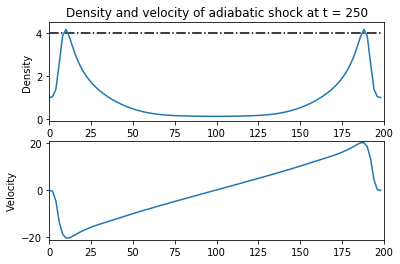

In [7]:
%matplotlib inline

fig2, axs2 = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs2[0].set_xlim([0,dx*Ngrid])
axs2[0].set_ylim([-0.1,4.5])
axs2[0].plot(x, np.ones(Ngrid)*4, 'k-.')
axs2[0].set_xlabel('Position')
axs2[0].set_ylabel('Density')
axs2[1].set_ylabel('Velocity')
axs2[1].set_xlim([0,dx*Ngrid])
axs2[1].set_ylim([-21,21])
axs2[0].plot(x, special_density)
axs2[1].plot(x, special_velocity)
axs2[0].set_title('Density and velocity of adiabatic shock at t = 250')
#plt.savefig('Density_plot_dt0005.png',format='png')

__Question 2__: The width of the shock is $\Delta d\thicksim\frac{\nu}{u}$, $\nu$ can be found by numerical viscosity $\frac{\Delta_x^2}{2\Delta_t} = \frac{2^2}{2\cdot0.01} = 200$. From the plot below, estimate $u = 20$, such that the width $\Delta d \thicksim 10$. Reading off the plot above, this is about the right order of magnitude. 

One can try to vary the spatial and temporal resolutions ($\Delta x$ and $\Delta t$) to see if the width changes.

I rerun this script, changing $\Delta t$ = 0.005. The expectation is that the width would double. Reading off the plot produced by this run (in the same repository, the file is named "Density_plot_dt0005"), the width is roughly 7 when the shock back is at $x$ = 150. This compares to the original case ($\Delta t$ = 0.01, file "density_plot_original"), for which the width is roughly 4 when the shock was at the same location, confirming the relationship.